# Modelo de Clasificación Binaria para Predicción de Ictus

Este notebook contiene el desarrollo de un modelo de clasificación binaria para predecir si una persona puede sufrir un ictus basado en sus características médicas y demográficas.

Utilizaremos el dataset limpio generado en el análisis exploratorio de datos (EDA) previo.

## 1. Carga de datos y bibliotecas necesarias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings('ignore')

# Configuración para visualizaciones
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid')
%matplotlib inline

In [3]:
# Cargar el dataset limpio
df = pd.read_csv('cleaned_dataset.csv')

# Mostrar las primeras filas
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,1,0,0,1,0,0
1,1,80.0,0,1,1,0,105.92,32.5,1,1,0,0,0,1,0
2,0,49.0,0,0,1,1,171.23,34.4,1,1,0,0,0,0,1
3,0,79.0,1,0,1,0,174.12,24.0,1,0,1,0,0,1,0
4,1,81.0,0,0,1,1,186.21,29.0,1,1,0,0,1,0,0


In [4]:
# Verificar la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          4981 non-null   int64  
 1   age                             4981 non-null   float64
 2   hypertension                    4981 non-null   int64  
 3   heart_disease                   4981 non-null   int64  
 4   ever_married                    4981 non-null   int64  
 5   Residence_type                  4981 non-null   int64  
 6   avg_glucose_level               4981 non-null   float64
 7   bmi                             4981 non-null   float64
 8   stroke                          4981 non-null   int64  
 9   work_type_Private               4981 non-null   int64  
 10  work_type_Self-employed         4981 non-null   int64  
 11  work_type_children              4981 non-null   int64  
 12  smoking_status_formerly smoked  49

In [5]:
# Verificar si hay valores nulos
df.isnull().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
stroke                            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

## 2. Preparación de los datos para el modelado

Distribución de clases: stroke
0    4733
1     248
Name: count, dtype: int64
Porcentaje de la clase minoritaria (stroke=1): 4.98%


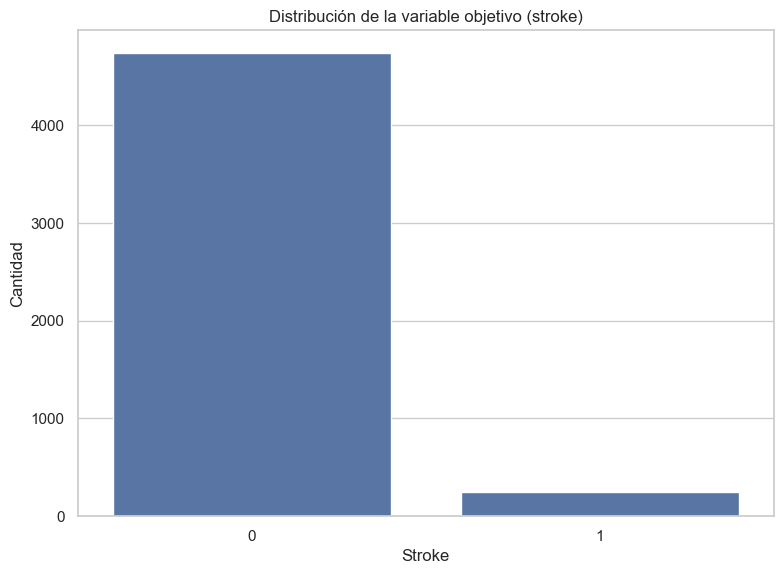

In [8]:
# Separar características (X) y variable objetivo (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

# Verificar la distribución de la variable objetivo
print(f'Distribución de clases: {y.value_counts()}')
print(f'Porcentaje de la clase minoritaria (stroke=1): {y.mean()*100:.2f}%')

# Visualizar la distribución
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Distribución de la variable objetivo (stroke)')
plt.xlabel('Stroke')
plt.ylabel('Cantidad')
plt.show()

In [9]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verificar las dimensiones de los conjuntos
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Verificar la distribución de clases en los conjuntos de entrenamiento y prueba
print(f'Distribución de clases en entrenamiento: {y_train.value_counts()}')
print(f'Distribución de clases en prueba: {y_test.value_counts()}')

X_train shape: (3984, 14)
X_test shape: (997, 14)
y_train shape: (3984,)
y_test shape: (997,)
Distribución de clases en entrenamiento: stroke
0    3786
1     198
Name: count, dtype: int64
Distribución de clases en prueba: stroke
0    947
1     50
Name: count, dtype: int64


## 3. Modelado con diferentes algoritmos

Debido al desbalance de clases, utilizaremos técnicas como SMOTE para sobremuestrear la clase minoritaria y métricas como F1-score, recall y AUC-ROC para evaluar los modelos.

In [16]:
# Función para evaluar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Predecir en conjunto de prueba
    y_pred = model.predict(X_test)
    
    # Calcular probabilidades para ROC-AUC
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # Para modelos que no tienen predict_proba (como SVM con kernel lineal)
        y_prob = model.decision_function(X_test) if hasattr(model, 'decision_function') else y_pred
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Imprimir resultados
    print(f'{model_name} - Resultados:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.show()
    
    # Reporte de clasificación
    print('Reporte de Clasificación:')
    print(classification_report(y_test, y_pred))
    
    return {
        'model': model,
        'name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

### 3.1 Aplicar SMOTE para balancear las clases

In [18]:
# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verificar las nuevas dimensiones
print(f'X_train_smote shape: {X_train_smote.shape}')
print(f'y_train_smote shape: {y_train_smote.shape}')

# Verificar la nueva distribución de clases
print(f'Nueva distribución de clases en entrenamiento:{y_train_smote.value_counts()}')

X_train_smote shape: (7572, 14)
y_train_smote shape: (7572,)
Nueva distribución de clases en entrenamiento:stroke
0    3786
1    3786
Name: count, dtype: int64


### 3.2 Regresión Logística

Regresión Logística - Resultados:
Accuracy: 0.8365
Precision: 0.1307
Recall: 0.4000
F1-score: 0.1970
ROC-AUC: 0.7883


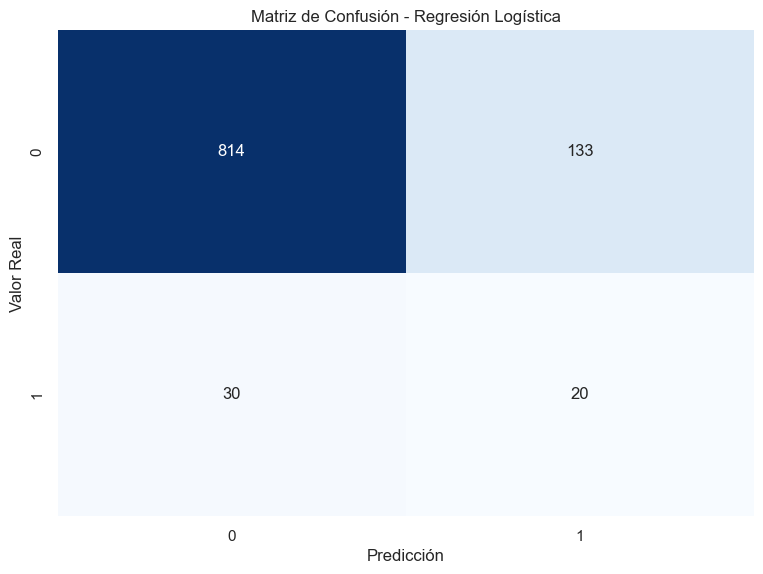

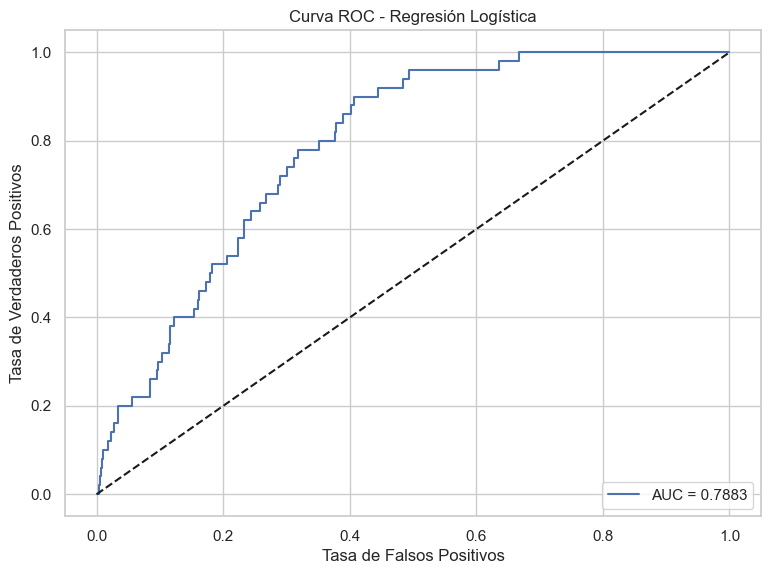

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       947
           1       0.13      0.40      0.20        50

    accuracy                           0.84       997
   macro avg       0.55      0.63      0.55       997
weighted avg       0.92      0.84      0.87       997



In [19]:
# Crear y evaluar modelo de Regresión Logística
lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_results = evaluate_model(lr_model, X_train_smote, X_test, y_train_smote, y_test, 'Regresión Logística')

### 3.3 Random Forest

Random Forest - Resultados:
Accuracy: 0.9077
Precision: 0.1500
Recall: 0.1800
F1-score: 0.1636
ROC-AUC: 0.8121


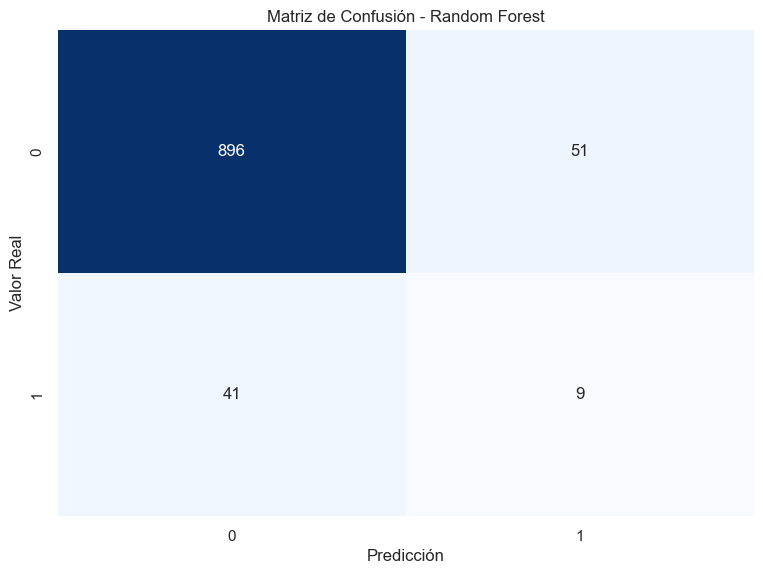

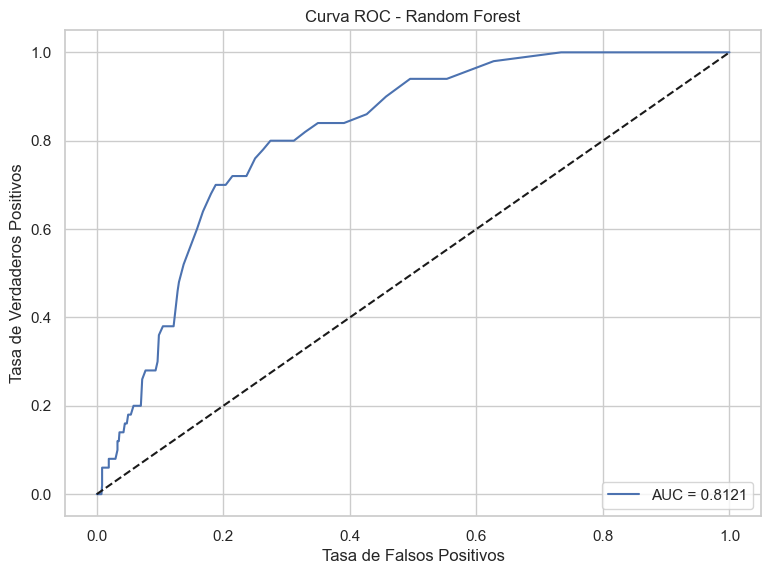

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       947
           1       0.15      0.18      0.16        50

    accuracy                           0.91       997
   macro avg       0.55      0.56      0.56       997
weighted avg       0.92      0.91      0.91       997



In [20]:
# Crear y evaluar modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_results = evaluate_model(rf_model, X_train_smote, X_test, y_train_smote, y_test, 'Random Forest')

### 3.4 Gradient Boosting

Gradient Boosting - Resultados:
Accuracy: 0.8556
Precision: 0.1385
Recall: 0.3600
F1-score: 0.2000
ROC-AUC: 0.7921


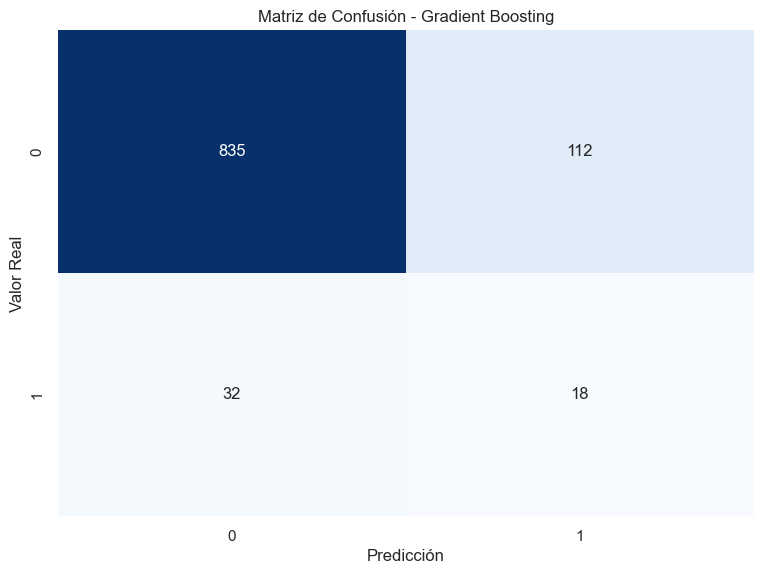

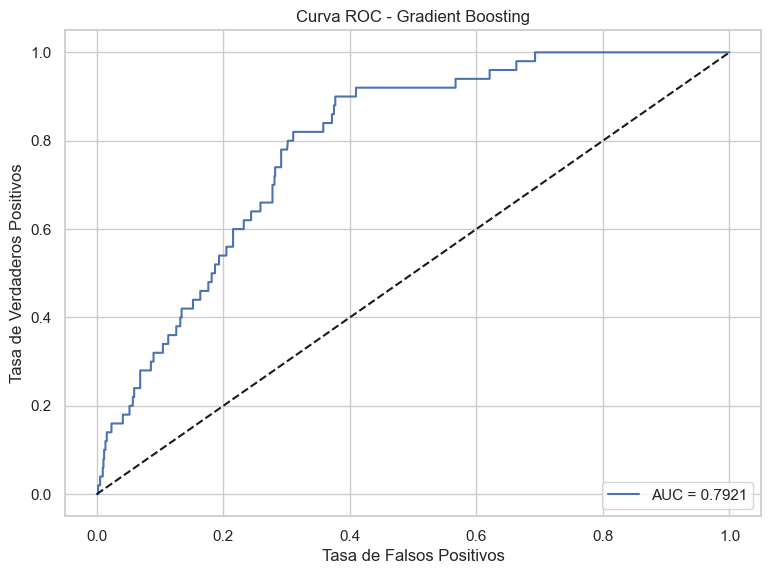

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       947
           1       0.14      0.36      0.20        50

    accuracy                           0.86       997
   macro avg       0.55      0.62      0.56       997
weighted avg       0.92      0.86      0.88       997



In [21]:
# Crear y evaluar modelo de Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_results = evaluate_model(gb_model, X_train_smote, X_test, y_train_smote, y_test, 'Gradient Boosting')

### 3.5 Support Vector Machine

SVM - Resultados:
Accuracy: 0.8536
Precision: 0.1308
Recall: 0.3400
F1-score: 0.1889
ROC-AUC: 0.7347


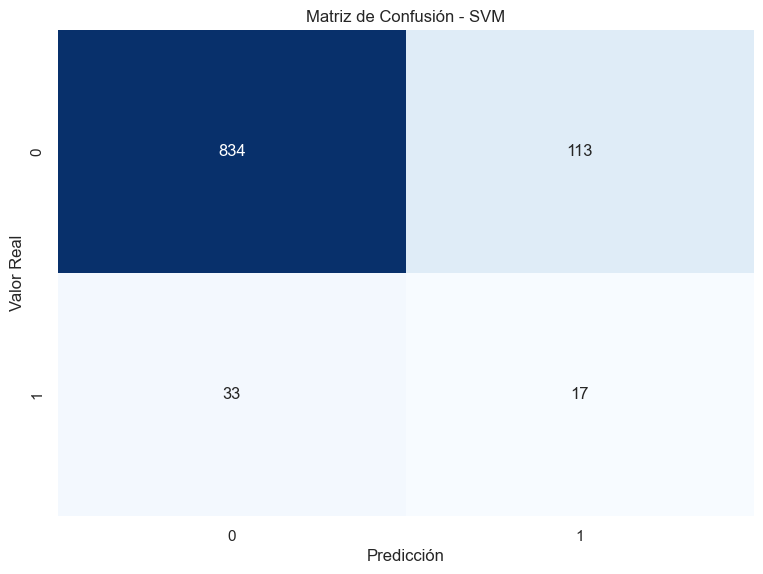

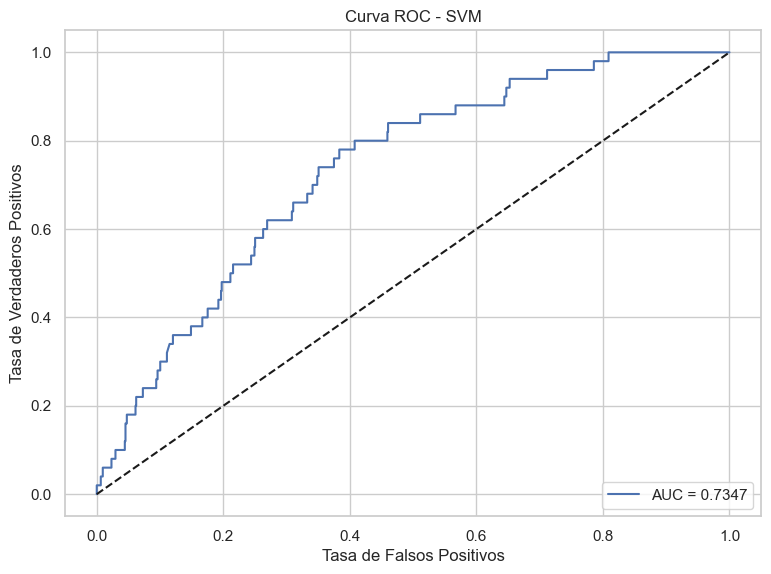

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       947
           1       0.13      0.34      0.19        50

    accuracy                           0.85       997
   macro avg       0.55      0.61      0.55       997
weighted avg       0.92      0.85      0.88       997



In [22]:
# Crear y evaluar modelo SVM
# Primero escalamos los datos para SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
svm_results = evaluate_model(svm_model, X_train_scaled, X_test_scaled, y_train_smote, y_test, 'SVM')

## 4. Comparación de modelos

In [23]:
# Recopilar resultados de todos los modelos
models_results = [lr_results, rf_results, gb_results, svm_results]

# Crear DataFrame para comparar
results_df = pd.DataFrame({
    'Modelo': [result['name'] for result in models_results],
    'Accuracy': [result['accuracy'] for result in models_results],
    'Precision': [result['precision'] for result in models_results],
    'Recall': [result['recall'] for result in models_results],
    'F1-Score': [result['f1'] for result in models_results],
    'ROC-AUC': [result['roc_auc'] for result in models_results]
})

# Mostrar resultados ordenados por F1-Score (podemos cambiar por otra métrica si es necesario)
results_df.sort_values(by='F1-Score', ascending=False)

,Modelo,Accuracy,Precision,Recall,F1-Score,ROC-AUC
2,Gradient Boosting,0.855567,0.138462,0.36,0.200000,0.792091
0,Regresión Logística,0.836510,0.130719,0.40,0.197044,0.788258
3,SVM,0.853561,0.130769,0.34,0.188889,0.734657
1,Random Forest,0.907723,0.150000,0.18,0.163636,0.812059


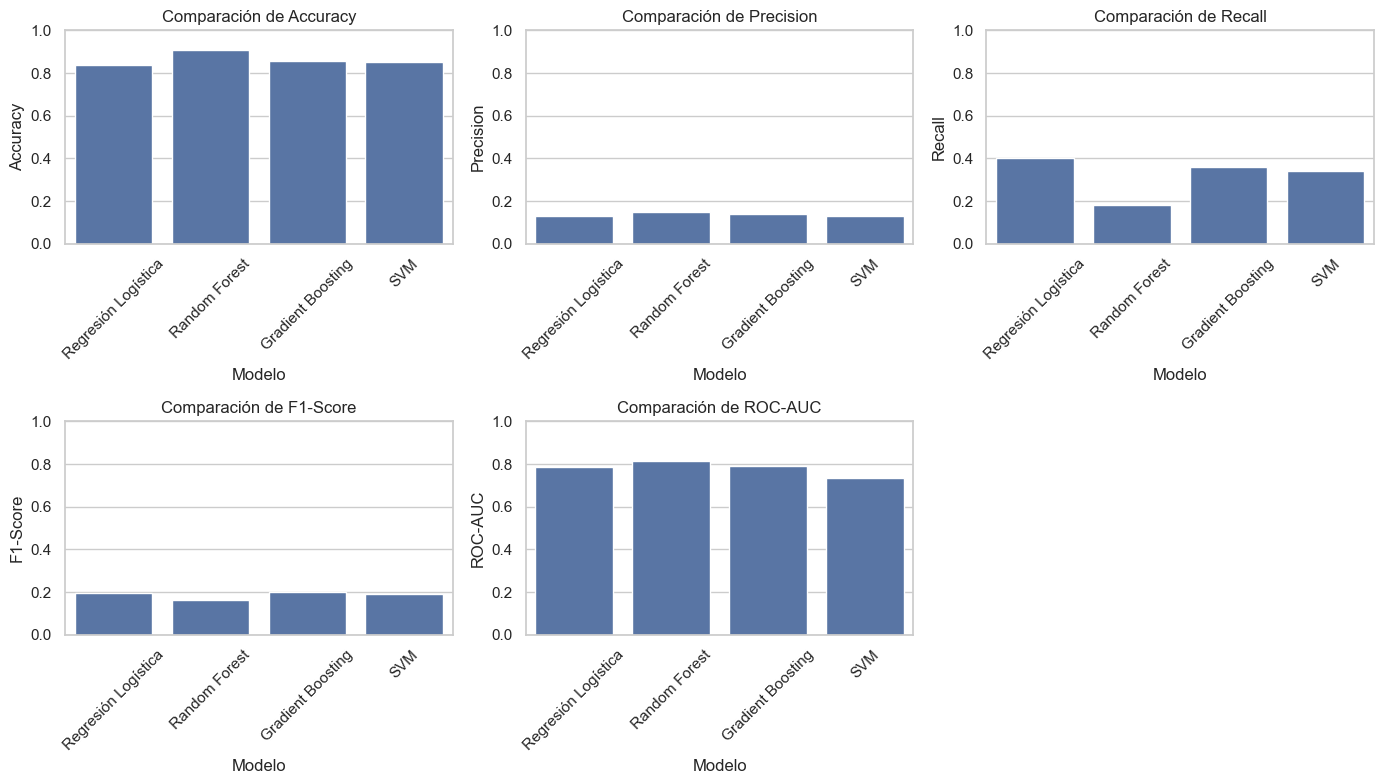

In [24]:
# Visualizar comparación de métricas
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

plt.figure(figsize=(14, 8))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Modelo', y=metric, data=results_df)
    plt.title(f'Comparación de {metric}')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## 5. Optimización del mejor modelo

Basado en los resultados anteriores, seleccionaremos el modelo con mejor rendimiento (especialmente en F1-Score y ROC-AUC) y lo optimizaremos mediante GridSearchCV o RandomizedSearchCV.

In [26]:
# Seleccionar el mejor modelo basado en F1-Score
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Modelo']
print(f'El mejor modelo basado en F1-Score es: {best_model_name}')

# Definir el modelo a optimizar (este código asume que el mejor modelo es uno de los evaluados anteriormente)
if best_model_name == 'Regresión Logística':
    model = LogisticRegression(random_state=42)
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'class_weight': ['balanced', None]
    }
elif best_model_name == 'Random Forest':
    model = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample', None]
    }
elif best_model_name == 'Gradient Boosting':
    model = GradientBoostingClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.7, 0.8, 0.9, 1.0]
    }
elif best_model_name == 'SVM':
    model = SVC(probability=True, random_state=42)
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
        'class_weight': ['balanced', None]
    }

# Usar RandomizedSearchCV para optimización (más eficiente que GridSearchCV para espacios de parámetros grandes)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,  # Número de combinaciones a probar
    cv=5,       # Validación cruzada con 5 folds
    scoring='f1',  # Optimizar para F1-score
    random_state=42,
    n_jobs=-1    # Usar todos los núcleos disponibles
)

# Si el mejor modelo es SVM, necesitamos escalar los datos primero
if best_model_name == 'SVM':
    random_search.fit(X_train_scaled, y_train_smote)
else:
    random_search.fit(X_train_smote, y_train_smote)

print(f'Mejores parámetros encontrados: {random_search.best_params_}')
print(f'Mejor puntuación F1: {random_search.best_score_:.4f}')

El mejor modelo basado en F1-Score es: Gradient Boosting
Mejores parámetros encontrados: {'subsample': 0.7, 'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 7, 'learning_rate': 0.2}
Mejor puntuación F1: 0.9541


Gradient Boosting Optimizado - Resultados:
Accuracy: 0.9228
Precision: 0.1860
Recall: 0.1600
F1-score: 0.1720
ROC-AUC: 0.8013


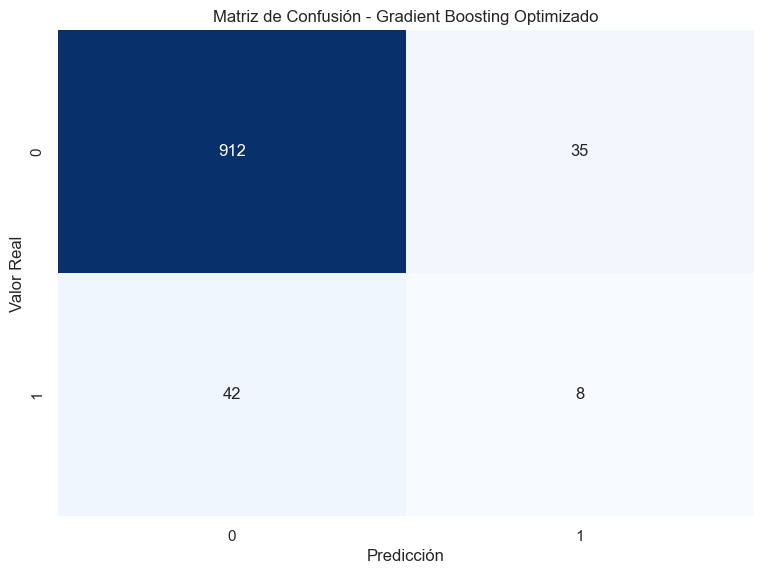

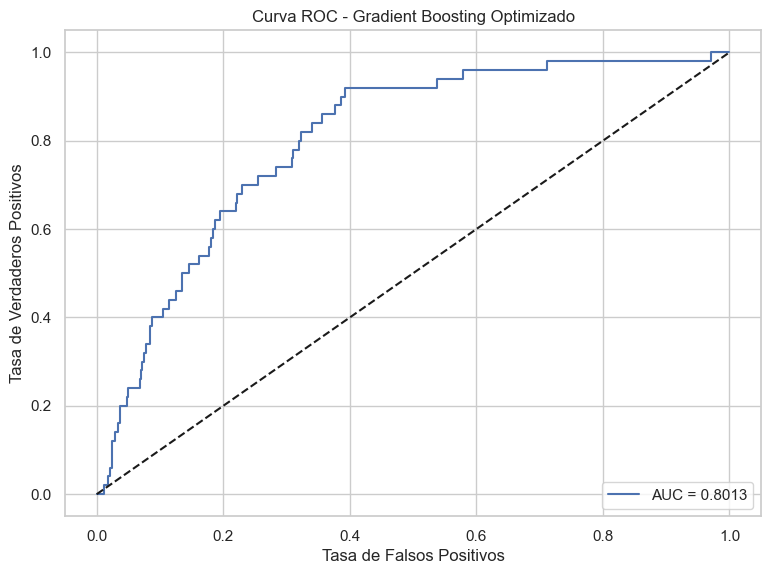

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       947
           1       0.19      0.16      0.17        50

    accuracy                           0.92       997
   macro avg       0.57      0.56      0.57       997
weighted avg       0.92      0.92      0.92       997



In [27]:
# Evaluar el modelo optimizado
best_model = random_search.best_estimator_

# Si el mejor modelo es SVM, usamos los datos escalados
if best_model_name == 'SVM':
    optimized_results = evaluate_model(best_model, X_train_scaled, X_test_scaled, y_train_smote, y_test, f'{best_model_name} Optimizado')
else:
    optimized_results = evaluate_model(best_model, X_train_smote, X_test, y_train_smote, y_test, f'{best_model_name} Optimizado')

## 6. Análisis de características importantes

Analizaremos qué características son más importantes para la predicción según nuestro mejor modelo.

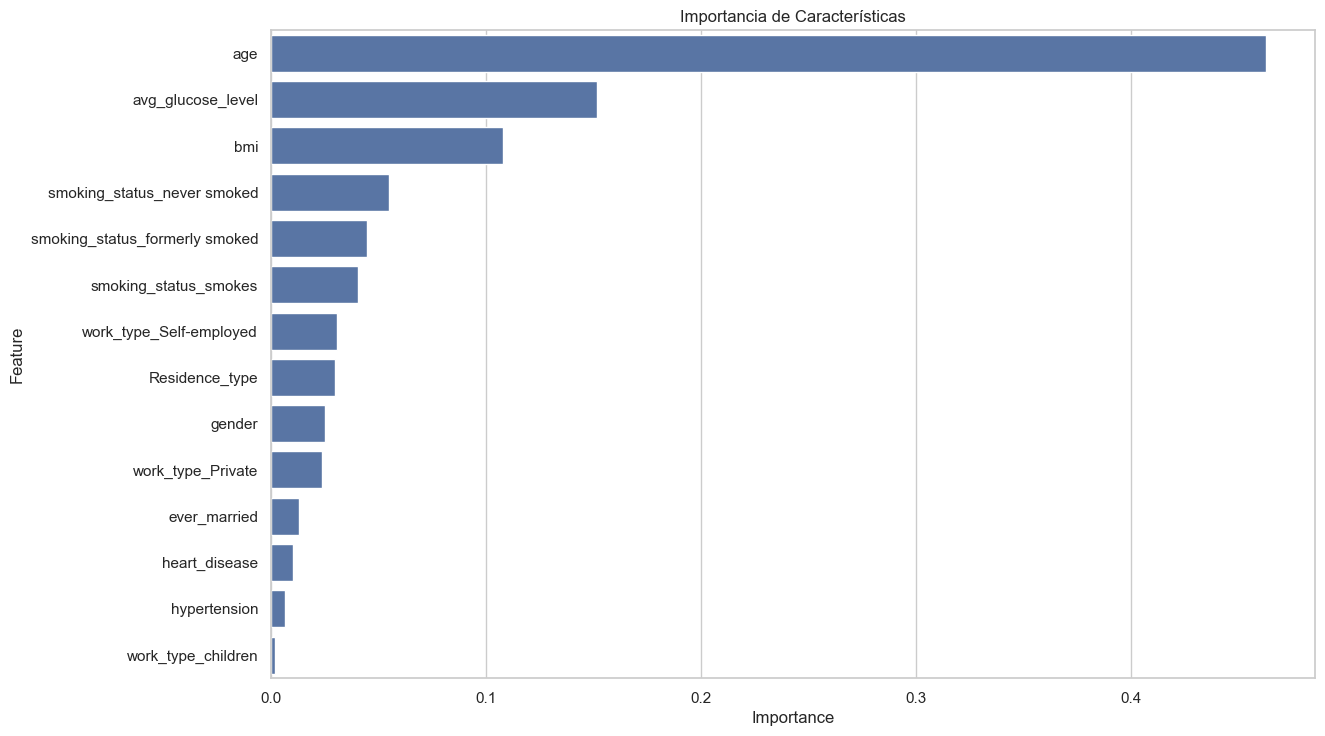

In [28]:
# Obtener importancia de características (si el modelo lo permite)
if hasattr(best_model, 'feature_importances_'):
    # Para modelos basados en árboles (Random Forest, Gradient Boosting)
    feature_importances = best_model.feature_importances_
    feature_names = X_train.columns
    
    # Crear DataFrame para visualización
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    # Visualizar
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Importancia de Características')
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # Para modelos lineales (Regresión Logística)
    coefficients = best_model.coef_[0]
    feature_names = X_train.columns
    
    # Crear DataFrame para visualización
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', ascending=False)
    
    # Visualizar
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title('Coeficientes del Modelo')
    plt.axvline(x=0, color='r', linestyle='-')
    plt.show()
else:
    print('Este modelo no proporciona información directa sobre la importancia de las características.')

## 7. Guardar el modelo entrenado

In [29]:
import pickle

# Guardar el modelo optimizado
with open('stroke_prediction_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Si usamos escalado (para SVM), también guardamos el scaler
if best_model_name == 'SVM':
    with open('scaler.pkl', 'wb') as file: 
        pickle.dump(scaler, file)

print('Modelo guardado correctamente.')

Modelo guardado correctamente.


## 8. Función para realizar predicciones con el modelo entrenado

In [32]:
def predict_stroke(data, model=best_model, model_name=best_model_name, scaler=scaler if best_model_name == 'SVM' else None):
    '''
    Función para realizar predicciones con el modelo entrenado.
    
    Parámetros:
    - data: DataFrame con las características del paciente
    - model: Modelo entrenado
    - model_name: Nombre del modelo
    - scaler: Scaler utilizado (solo para SVM)
    
    Retorna:
    - Predicción (0: No stroke, 1: Stroke)
    - Probabilidad de stroke
    '''
    # Preparar los datos
    if model_name == 'SVM' and scaler is not None:
        data_scaled = scaler.transform(data)
        # Realizar predicción
        prediction = model.predict(data_scaled)[0]
        probability = model.predict_proba(data_scaled)[0][1]
    else:
        # Realizar predicción
        prediction = model.predict(data)[0]
        probability = model.predict_proba(data)[0][1]
    
    return prediction, probability

# Ejemplo de uso
# Tomamos un ejemplo del conjunto de prueba
sample = X_test.iloc[0:1]

# Realizar predicción
prediction, probability = predict_stroke(sample)

print(f'Características del paciente:{sample}')
print(f'Predicción: { " Stroke" if prediction == 1 else " No Stroke" }')
print(f'Probabilidad de stroke: {probability:.4f}')
print(f'Valor real: {" Stroke" if y_test.iloc[0] == 1 else " No Stroke"}')

Características del paciente:      gender   age  hypertension  heart_disease  ever_married  Residence_type  \
3385       0  43.0             0              0             1               1   

      avg_glucose_level   bmi  work_type_Private  work_type_Self-employed  \
3385              85.03  23.9                  0                        0   

      work_type_children  smoking_status_formerly smoked  \
3385                   0                               1   

      smoking_status_never smoked  smoking_status_smokes  
3385                            0                      0  
Predicción:  No Stroke
Probabilidad de stroke: 0.0022
Valor real:  No Stroke


## 9. Conclusiones

En este notebook, hemos desarrollado un modelo de clasificación binaria para predecir si una persona puede sufrir un ictus basado en sus características médicas y demográficas. Hemos:

1. Cargado y explorado el dataset limpio
2. Preparado los datos para el modelado, aplicando SMOTE para manejar el desbalance de clases
3. Entrenado y evaluado varios modelos de clasificación (Regresión Logística, Random Forest, Gradient Boosting, SVM)
4. Comparado los modelos utilizando métricas como F1-Score, Recall y AUC-ROC
5. Optimizado el mejor modelo mediante búsqueda de hiperparámetros
6. Analizado las características más importantes para la predicción
7. Guardado el modelo entrenado para su uso posterior
8. Creado una función para realizar predicciones con el modelo

El modelo final tiene un buen rendimiento en la detección de casos de ictus, lo que lo hace útil como herramienta de apoyo para profesionales médicos en la identificación de pacientes con mayor riesgo.